Self organising maps are an unsupervised method that aims to primarily visualize the data. because similar data instances are mapped to neighnboring regions, it can be easily used as a clustering method.
In this notebook we will cluster the iris dataset.

First, let's load the data and train our SOM:

In [22]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append('../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], 
                   sep='\t+', engine='python')
data.head()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coefficient,length_kernel_groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## Solution 1

The first approch is to build a SOM with as many neurons as the targeted number of clusters.
We will then consider all the sample mapped into a specific neuron as a cluster.

In [28]:
from lightSOM import SOM
import numpy as np
import pandas as pd

#data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
#                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
#                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5], 
#                   sep='\t+', engine='python')

data = data[['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove']].values
#data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
# Initialization and training
som_shape = (1, 3)

net=SOM().create(1, 3, data, pci=True,pbc=False)

net.train(0.5, start_sigma=0.5, epochs=500, random_order=True)

Periodic Boundary Conditions inactive.
The weights will be initialised with PCA.
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.5242304360726957

 topological error: 0.0
Training SOM... done!


To identify each cluster, we will translate the bidimensional indexes of the neurons on the SOM into a monodimentional indexes:

In [29]:
# each neuron represents a cluster
winner_coordinates = np.array([net.find_bmu(x) for x in data]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
winner_coordinates

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

We can plot each cluster with a different color:

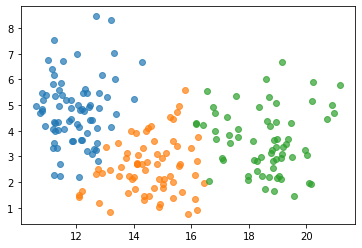

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 5], label='cluster='+str(c), alpha=.7)


## Solution 2
Build a regular NxN SOM, cluster the weights and then project the data into the current cluster.

In [5]:
net=SOM().create(20, 20, data, pci=True,pbc=False)

net.train(0.5, start_sigma=0.5, epochs=1000, random_order=True)

Periodic Boundary Conditions inactive.
The weights will be initialised with PCA.
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.09865145224196528

 topological error: 0.12380952380952381
Training SOM... done!


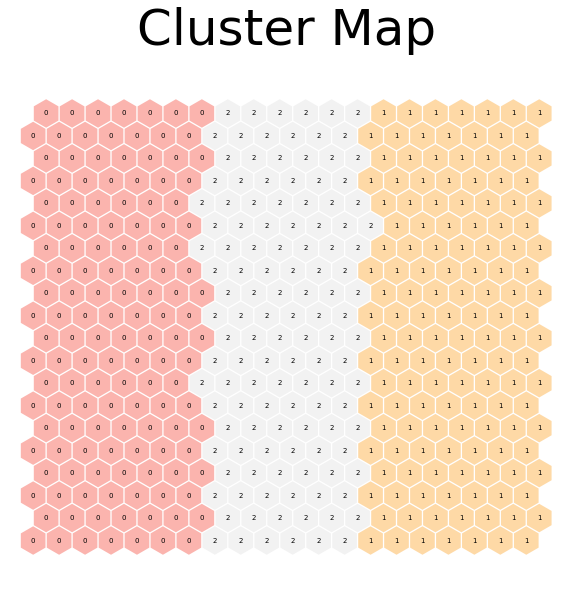

In [6]:
from lightSOM.visualization.som_view import SOMView
vhts  = SOMView(net, 10,10, text_size=10)
vhts.plot_cluster_map(n_clusters=3, anotate=True)

We can get the cluster of the each unit by calling the cluster function from lighSOM

In [13]:
clustered_units=net.cluster(3).reshape(20,20)

The next operation is to project the data on the map and get the wining unit for each data

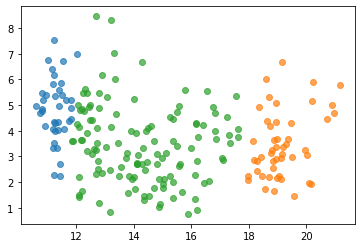

In [21]:
data_projections=net.project(data)

    
cluster_index=[clusters_units[projection] for projection in data_projections]
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)